In [1]:
# Import necessary libraries
from __future__ import division, print_function, unicode_literals

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.usetex'] = False

import tensorflow as tf
import numpy as np
from functools import partial
import glob, os
import pickle
import copy
from PDEsolvers import HeatEqn_FT

In [11]:
# User inputs
data_train_len = 20  # Number of training data files
data_name = 'Heat_Eqn_exp29'  # Prefix of data files
folder_name = 'Heat_exp29m/'  # Folder to be created for saved output

In [12]:
# Find the model with lowest validation error
import math

def BestErrorFile(folder_name):

    filename_best = ''
    best_error = 10**6

    current_dir = os.getcwd()
    os.chdir("./" + folder_name)
    for file in glob.glob("*.pkl"):
        with open(file, 'rb') as f:
            params = pickle.load(f)
            if not math.isnan(params['minRegTest']):
                if params['minRegTest'] < best_error:
                    filename_best = file
                    best_error = params['minRegTest']
    os.chdir(current_dir)

    return filename_best

pkl_file = folder_name + BestErrorFile(folder_name)

with open(pkl_file, 'rb') as f:
     params = pickle.load(f)

params['model_restore_path'] = params['model_path']
print(pkl_file)
print(params['minTest'])
print(params['minTrain'])

Heat_exp29m/Heat_Eqn_exp29_2019_10_28_10_57_58_868266_model.pkl
0.0448733676224947
0.040677424520254135


In [4]:
# Create numpy arrays with data

# Use these lines to load all data
data_train = np.load(('./data/%s_train1_x.npy' % (data_name)))
data_val = np.load(('./data/%s_val_x.npy' % data_name))
#data_test = np.load(('./data/%s_test_x.npy' % data_name))


In [5]:
import helperfns_convnet

max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
data_val_tensor = helperfns_convnet.stack_data(data_val, max_shifts_to_stack, params['val_len_time'])
data_train_tensor = helperfns_convnet.stack_data(data_train, max_shifts_to_stack, params['train_len_time'][0])
#data_test_tensor = helperfns_convnet.stack_data(data_test, max_shifts_to_stack, params['val_len_time'])

In [13]:
# Get all the needed things from the network

tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
    
    L_mat = sess.run(tf.get_default_graph().get_tensor_by_name("dynamics/L:0"))
    FT = sess.run(tf.get_default_graph().get_tensor_by_name("encoder/FT:0"))
    IFT = sess.run(tf.get_default_graph().get_tensor_by_name("decoder_inner/IFT:0"))
    
    max_shifts_to_stack = helperfns_convnet.num_shifts_in_stack(params)
    # Prediction
    beg = 2*max_shifts_to_stack+3
    end = beg + params['num_shifts']
    tensor_list = ["decoder_outer/outputs:0"]
    for k in np.arange(beg,end):
        tensor_list.append("decoder_outer_"+str(k)+"/outputs:0")
    
    train_outputs = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor}) 
    val_outputs = sess.run(tensor_list, feed_dict={"x:0": data_val_tensor}) 
    #test_outputs = sess.run(tensor_list, feed_dict={"x:0": data_test_tensor}) 
    
    
    # Encoded
    beg = 1
    end = max_shifts_to_stack+1
    tensor_list = ["encoder/vk_hat:0"]
    for k in np.arange(beg,end):
        tensor_list.append("encoder_"+str(k)+"/vk_hat:0") 
    train_encoded = sess.run(tensor_list, feed_dict={"x:0": data_train_tensor})
    val_encoded = sess.run(tensor_list, feed_dict={"x:0": data_val_tensor})
    #test_encoded = sess.run(tensor_list, feed_dict={"x:0": data_test_tensor})
    
train_encoded = np.asarray(train_encoded)
val_encoded = np.asarray(val_encoded)
#test_encoded = np.asarray(test_encoded)

train_outputs = np.asarray(train_outputs)
val_outputs = np.asarray(val_outputs)
#test_outputs = np.asarray(test_outputs)

INFO:tensorflow:Restoring parameters from ./Heat_exp29m/Heat_Eqn_exp29_2019_10_28_10_57_58_868266_model.ckpt


In [7]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            cmap = matplotlib.colors.ListedColormap(['red'])
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
        lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

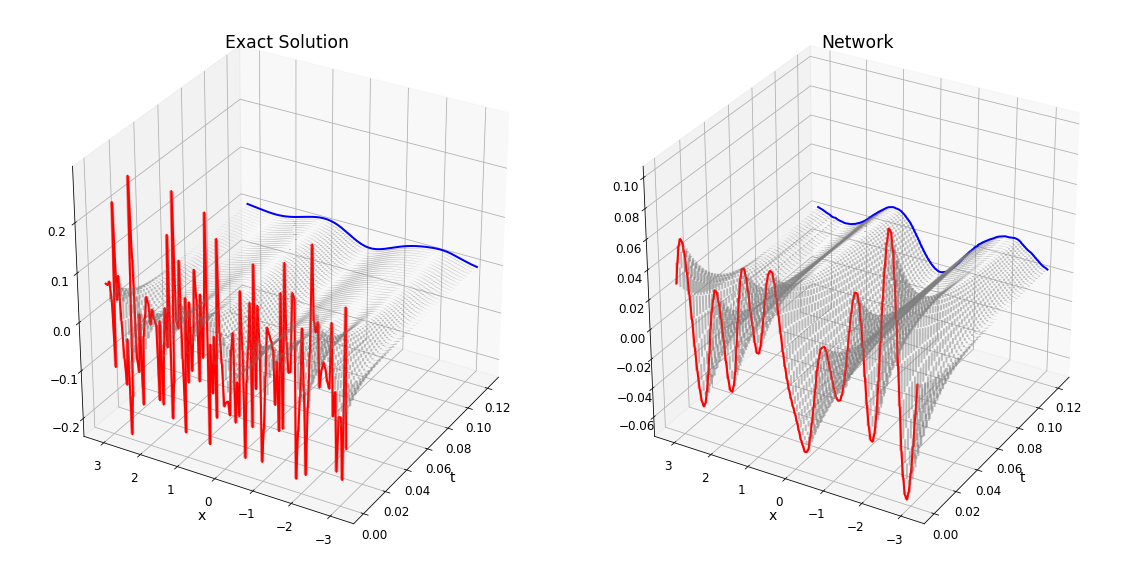

In [15]:
# Inputs
data = 'train'  # 'train', 'val', or 'test'
IC = 1 # index of initial condition

if data == 'train':
    outputs = train_outputs
    data_tensor = data_train_tensor
elif data == 'val':
    outputs = val_outputs
    data_tensor = data_val_tensor
else:
    outputs = test_outputs
    data_tensor = data_test_tensor


# Exact solution (from data set)
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
exact = data_tensor[0:,IC,:]

fig = plt.figure(figsize=(16,8)) 

ax = fig.add_subplot(1, 2, 1, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Exact Solution', fontsize='xx-large')

ax = fig.add_subplot(1, 2, 2, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(outputs[:,IC,:]),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], outputs[0,IC,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], outputs[-1,IC,:],'-b',linewidth=2)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=210)
ax.set_title('Network', fontsize='xx-large')

#ax = fig.add_subplot(2,2,3)
#ax.plot(x_pts, exact[-1,:], "b-", linewidth=2)
#ax.plot(x_pts, outputs[-1,ind,:], "r--", linewidth=2)
#ax.set_title('Final Time (50 time steps)', fontsize='xx-large')
plt.tight_layout()
plt.show()   
#filename = './MeetingUpdates/PaperFigs/Burgers_exp28d_IC' + str(IC)
#filename = './MeetingUpdates/PaperFigs/Burgers_exp28d_test'
#plt.savefig(filename)

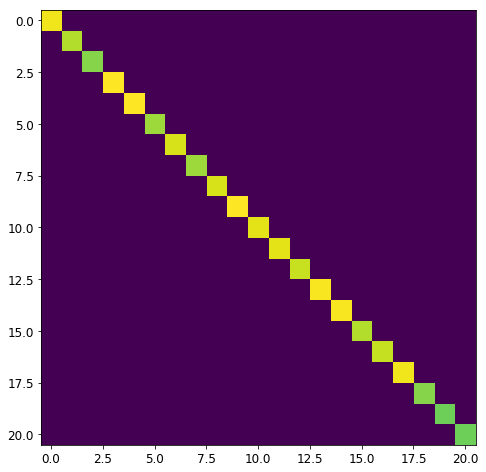

[-2.8371911e-03 -1.0075612e+00 -1.0533839e+00 -3.9744966e+00
 -4.0098233e+00 -8.9577856e+00 -9.0250607e+00 -1.5977790e+01
 -1.6001564e+01 -2.4961626e+01 -2.5065252e+01 -3.5903149e+01
 -3.5960739e+01 -4.8756485e+01 -4.9013233e+01 -6.3789417e+01
 -6.3965073e+01 -8.0550224e+01 -8.0602570e+01 -9.8884926e+01
 -9.9389389e+01]


In [14]:
# Check eigenvalues

plt.figure(figsize=(8,8))
plt.imshow(L_mat)
plt.show()


lam, V = np.linalg.eig(L_mat)
lam = np.log(lam)
ind = np.argsort(lam)
ind = np.flip(ind,0)
lam = np.sort(lam)
lam = np.flip(lam,0)
network_lam = lam/params['delta_t']
print(lam/params['delta_t'])

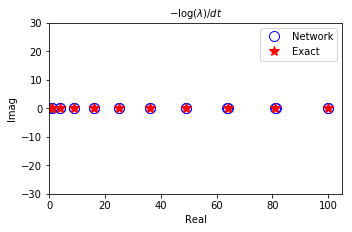

In [44]:
exact_lam = 0*lam

for k in np.arange(10):
    exact_lam[2*k+1:2*k+3] = [-(k+1)**2,-(k+1)**2]

plt.figure(figsize=(5,3.33))
Network, = plt.plot(-np.real(network_lam),np.imag(network_lam),'ob',markersize=10,markerfacecolor="None")
Exact, = plt.plot(-np.real(exact_lam),np.imag(exact_lam),'*r',markersize=10)
plt.ylim(-30,30)
plt.xlim(0,105)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.title('$-\log(\lambda)/dt$',fontsize=10)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend([Network,Exact],['Network','Exact'],fontsize=10)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/heat_eigenvalues.eps' 
plt.savefig(filename,format='eps')

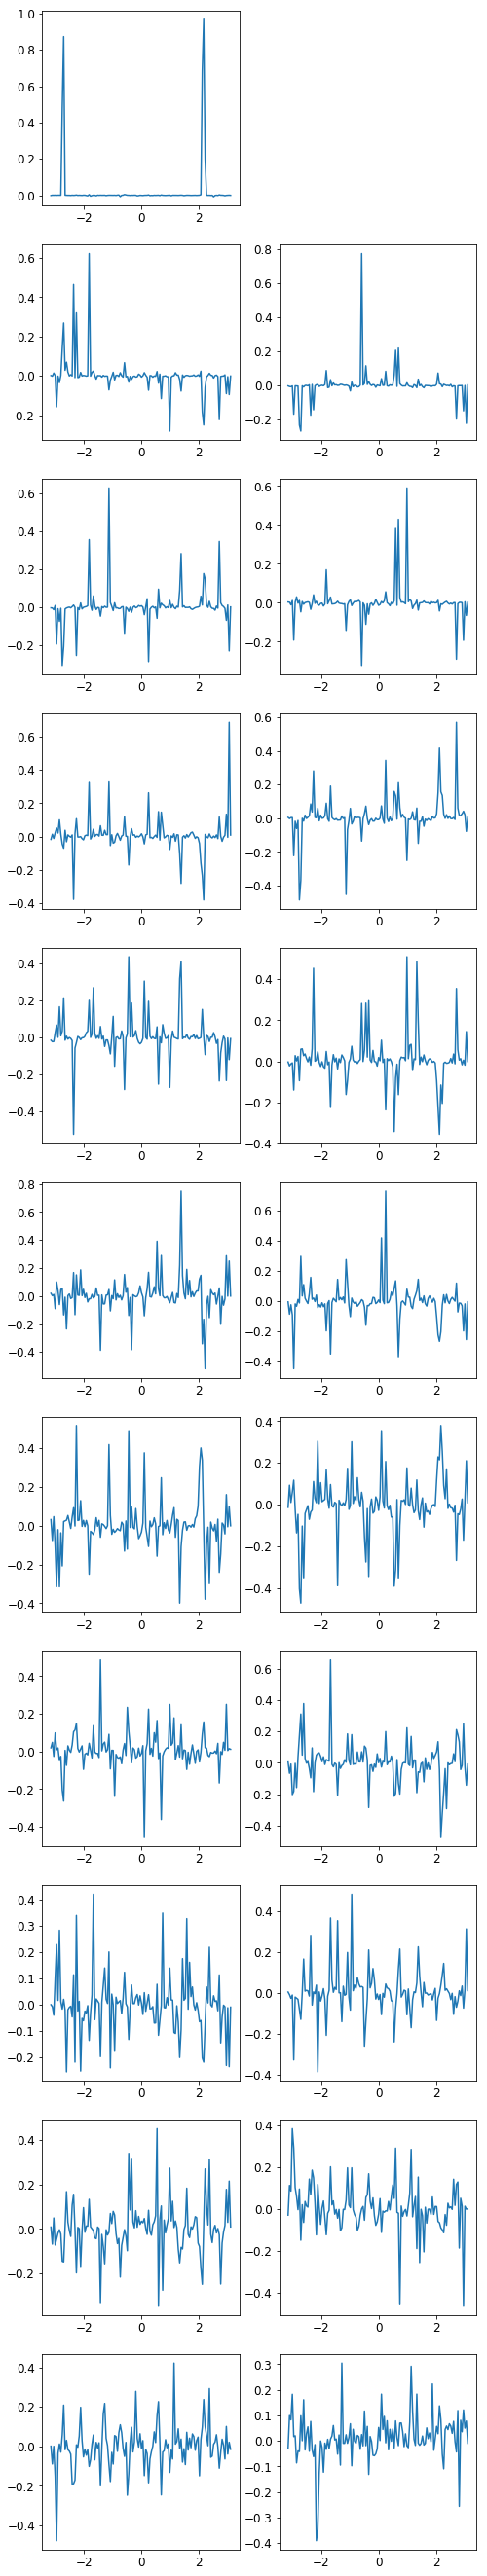

In [15]:
# Plot eigenvectors
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = V.T.dot(IFT)
f = np.real(f)

scale = np.zeros((21))
fig = plt.figure(figsize=(8,48)) 

ax = fig.add_subplot(11, 2, 1)
ax.plot(x_pts,f[ind[0],:])
scale[0] = np.linalg.norm(f[ind[0]])

for k in np.arange(10):
    ax = fig.add_subplot(11, 2, 2*k+3)
    ax.plot(x_pts,f[ind[2*k+1],:])
    scale[2*k+1] = np.linalg.norm(f[ind[2*k+1],:])
    
    ax = fig.add_subplot(11, 2, 2*k+4)
    ax.plot(x_pts,f[ind[2*k+2],:])
    scale[2*k+2] = np.linalg.norm(f[ind[2*k+2],:])
plt.show()

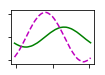

In [9]:
# Plot eigenvectors for a particular wavenumber
k = 1

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = V.T.dot(IFT)
f = np.real(f)

plt.figure(figsize=(1.5,1))
plt.plot(x_pts,f[ind[2*k-1],:],'-g',linewidth=1.5)
plt.plot(x_pts,f[ind[2*k],:],'--m',linewidth=1.5)
plt.xticks([-3,0,3], ['','',''])
plt.yticks([-0.1,0,0.1],['','',''])
#plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/heat_eigenfunction%d.eps' %(k) 
plt.savefig(filename,format='eps')

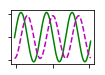

In [12]:
# Plot eigenvectors for a particular wavenumber
k = 3

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = V.T.dot(IFT)
f = np.real(f)

plt.figure(figsize=(1.5,1))
plt.plot(x_pts,f[ind[2*k-1],:],'-g',linewidth=1.5)
plt.plot(x_pts,f[ind[2*k],:],'--m',linewidth=1.5)
plt.xticks([-3,0,3], ['','',''])
plt.yticks([-0.25,0,0.25],['','',''])
filename = '../PDEKoopmanAutoencoder/figures/heat_eigenfunction%d.eps' %(k) 
plt.savefig(filename,format='eps')

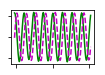

In [14]:
# Plot eigenvectors for a particular wavenumber
k = 8

x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]

f = V.T.dot(IFT)
f = np.real(f)

plt.figure(figsize=(1.5,1))
plt.plot(x_pts,f[ind[2*k-1],:],'-g',linewidth=1.5)
plt.plot(x_pts,f[ind[2*k],:],'--m',linewidth=1.5)
plt.xticks([-3,0,3], ['','',''])
plt.yticks([-0.5,0,0.5],['','',''])
filename = '../PDEKoopmanAutoencoder/figures/heat_eigenfunction%d.eps' %(k) 
plt.savefig(filename,format='eps')

In [13]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)

INFO:tensorflow:Restoring parameters from ./Heat_exp29m/Heat_Eqn_exp29_2019_08_22_17_50_03_034267_model.ckpt
save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
Adam_1/epsilon
Adam_1/beta2
Adam_1/beta1
Adam_1/learning_rate
decoder_inner/IFT/Adam_3
save/Assign_8
decoder_inner/IFT/Adam_3/read
decoder_inner/IFT/Adam_3/Initializer/zeros/Const
decoder_inner/IFT/Adam_3/Initializer/zeros/shape_as_tensor
decoder_inner/IFT/Adam_3/Initializer/zeros
decoder_inner/IFT/Adam_3/Assign
decoder_inner/IFT/Adam_2
save/Assign_7
decoder_inner/IFT/Adam_2/read
decoder_inner/IFT/Adam_2/Initializer/zeros/Const
decoder_inner/IFT/Adam_2/Initializer/zeros/shape_as_tensor
decoder_inner/IFT/Adam_2/Initializer/zeros
decoder_inner/IFT/Adam_2/Assign
encoder/FT/Adam_3
save/Assign_16
encoder/FT/Adam_3/read
encoder/FT/Adam_3/Initializer/zeros/Const
encoder/FT/Adam_3/Initializer/zeros/shape_as_tensor
encoder/FT/Adam_3/Initializer/zeros

gradients/add_54_grad/Shape_1
gradients/Mean_85_grad/Maximum_1/y
gradients/Mean_85_grad/Const_1
gradients/Mean_85_grad/Const
gradients/Mean_85_grad/Maximum/y
gradients/Mean_85_grad/Fill/value
gradients/Mean_85_grad/range/delta
gradients/Mean_85_grad/range/start
gradients/Mean_85_grad/Shape_1
gradients/Mean_85_grad/Fill
gradients/Mean_85_grad/Size
gradients/Mean_85_grad/range
gradients/Mean_80_grad/Maximum/y
gradients/Mean_80_grad/Const_1
gradients/Mean_80_grad/Const
gradients/Mean_80_grad/Shape_2
gradients/Mean_80_grad/Prod_1
gradients/Mean_80_grad/Maximum
gradients/Mean_80_grad/Reshape/shape
gradients/Mean_90_grad/Maximum_1/y
gradients/Mean_90_grad/Const_1
gradients/Mean_90_grad/Const
gradients/Mean_90_grad/Maximum/y
gradients/Mean_90_grad/Fill/value
gradients/Mean_90_grad/range/delta
gradients/Mean_90_grad/range/start
gradients/Mean_90_grad/Shape_1
gradients/Mean_90_grad/Fill
gradients/Mean_90_grad/Size
gradients/Mean_90_grad/range
gradients/add_56_grad/Shape_1
gradients/Mean_88_grad

Mean_40/reduction_indices
gradients/Mean_40_grad/add
gradients/Mean_40_grad/mod
add_24/y
Mean_39/reduction_indices
gradients/Mean_39_grad/add
gradients/Mean_39_grad/mod
mul_10/x
Const_163
Mean_37/reduction_indices
gradients/Mean_37_grad/add
gradients/Mean_37_grad/mod
add_22/y
Mean_36/reduction_indices
gradients/Mean_36_grad/add
gradients/Mean_36_grad/mod
mul_9/x
Const_162
Mean_34/reduction_indices
gradients/Mean_34_grad/add
gradients/Mean_34_grad/mod
add_20/y
Mean_33/reduction_indices
gradients/Mean_33_grad/add
gradients/Mean_33_grad/mod
mul_8/x
Const_161
Mean_31/reduction_indices
gradients/Mean_31_grad/add
gradients/Mean_31_grad/mod
add_18/y
Mean_30/reduction_indices
gradients/Mean_30_grad/add
gradients/Mean_30_grad/mod
mul_7/x
Const_160
Mean_28/reduction_indices
gradients/Mean_28_grad/add
gradients/Mean_28_grad/mod
add_16/y
Mean_27/reduction_indices
gradients/Mean_27_grad/add
gradients/Mean_27_grad/mod
mul_6/x
Const_159
Mean_25/reduction_indices
gradients/Mean_25_grad/add
gradients/M

gradients/Mean_150_grad/floordiv_1
gradients/Mean_150_grad/Cast
gradients/add_98_grad/Shape
gradients/add_98_grad/BroadcastGradientArgs
add_98
gradients/truediv_50_grad/Shape_1
Identity_150
decoder_inner_50/MatMul
gradients_1/decoder_outer_50/mul_grad/Shape_1
gradients_1/decoder_outer_50/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_50/mul_grad/Shape_1
gradients/decoder_outer_50/mul_grad/BroadcastGradientArgs
decoder_outer_50/mul
gradients_1/decoder_outer_50/outputs_grad/Shape_1
gradients/decoder_outer_50/outputs_grad/Shape_1
Identity_151
decoder_outer_50/log_vkplus1
gradients_1/decoder_outer_50/outputs_grad/Shape
gradients_1/decoder_outer_50/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_50/outputs_grad/Shape
gradients/decoder_outer_50/outputs_grad/BroadcastGradientArgs
decoder_outer_50/outputs
strided_slice_48
Squeeze_48
encoder_48/mul
Identity_48
encoder_48/log_uk
encoder_48/Add
encoder_48/v_k
decoder_outer_99/mul
Identity_200
decoder_outer_99/log_vkplus1
decode

gradients/Mean_78_grad/Prod
gradients/Mean_78_grad/Shape
gradients/Mean_78_grad/DynamicStitch
gradients/Mean_78_grad/Maximum
gradients/Mean_78_grad/floordiv
Mean_78
gradients/Mean_78_grad/Shape_3
gradients/Mean_78_grad/Prod_1
gradients/Mean_78_grad/Maximum_1
gradients/Mean_78_grad/floordiv_1
gradients/Mean_78_grad/Cast
gradients/add_50_grad/Shape
gradients/add_50_grad/BroadcastGradientArgs
add_50
gradients/truediv_26_grad/Shape_1
Identity_102
decoder_inner_26/MatMul
gradients_1/decoder_outer_26/mul_grad/Shape_1
gradients_1/decoder_outer_26/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_26/mul_grad/Shape_1
gradients/decoder_outer_26/mul_grad/BroadcastGradientArgs
decoder_outer_26/mul
gradients_1/decoder_outer_26/outputs_grad/Shape_1
gradients/decoder_outer_26/outputs_grad/Shape_1
Identity_103
decoder_outer_26/log_vkplus1
gradients_1/decoder_outer_26/outputs_grad/Shape
gradients_1/decoder_outer_26/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_26/outputs_grad/Shape
gr

gradients/decoder_outer_8/mul_grad/Shape_1
gradients/decoder_outer_8/mul_grad/BroadcastGradientArgs
decoder_outer_8/mul
gradients_1/decoder_outer_8/outputs_grad/Shape_1
gradients/decoder_outer_8/outputs_grad/Shape_1
Identity_67
decoder_outer_8/log_vkplus1
gradients_1/decoder_outer_8/outputs_grad/Shape
gradients_1/decoder_outer_8/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_8/outputs_grad/Shape
gradients/decoder_outer_8/outputs_grad/BroadcastGradientArgs
decoder_outer_8/outputs
strided_slice_6
Squeeze_6
encoder_6/mul
Identity_6
encoder_6/log_uk
encoder_6/Add
encoder_6/v_k
decoder_outer_57/mul
Identity_158
decoder_outer_57/log_vkplus1
decoder_outer_57/outputs
encoder_6/vk_hat
gradients/sub_7_grad/Shape_1
Square_14
gradients/Mean_21_grad/Shape_2
gradients/Mean_21_grad/Prod
gradients/Mean_21_grad/Shape
gradients/Mean_21_grad/DynamicStitch
gradients/Mean_21_grad/Maximum
gradients/Mean_21_grad/floordiv
Mean_21
gradients/Mean_21_grad/Shape_3
gradients/Mean_21_grad/Prod_1
gradien

gradients/truediv_41_grad/RealDiv_2
gradients/truediv_41_grad/Shape
gradients/truediv_41_grad/BroadcastGradientArgs
truediv_41
gradients/Mean_125_grad/Shape_1
gradients/Mean_125_grad/Prod
gradients/Mean_125_grad/floordiv
gradients/Mean_125_grad/Cast
gradients/Mean_125_grad/Shape
Mean_125
mul_39
sub_40
Square_81
gradients/Mean_121_grad/Shape_2
gradients/Mean_121_grad/Prod
gradients/Mean_121_grad/Shape
gradients/Mean_121_grad/DynamicStitch
gradients/Mean_121_grad/Maximum
gradients/Mean_121_grad/floordiv
Mean_121
gradients/Mean_121_grad/Shape_3
gradients/Mean_121_grad/Prod_1
gradients/Mean_121_grad/Maximum_1
gradients/Mean_121_grad/floordiv_1
gradients/Mean_121_grad/Cast
gradients/truediv_40_grad/Neg
gradients/truediv_40_grad/RealDiv_1
gradients/truediv_40_grad/RealDiv_2
gradients/truediv_40_grad/Shape
gradients/truediv_40_grad/BroadcastGradientArgs
truediv_40
gradients/Mean_122_grad/Shape_1
gradients/Mean_122_grad/Prod
gradients/Mean_122_grad/floordiv
gradients/Mean_122_grad/Cast
gradien

gradients/Mean_13_grad/floordiv
Mean_13
gradients/Mean_13_grad/Shape_3
gradients/Mean_13_grad/Prod_1
gradients/Mean_13_grad/Maximum_1
gradients/Mean_13_grad/floordiv_1
gradients/Mean_13_grad/Cast
gradients/truediv_4_grad/Neg
gradients/truediv_4_grad/RealDiv_1
gradients/truediv_4_grad/RealDiv_2
gradients/truediv_4_grad/Shape
gradients/truediv_4_grad/BroadcastGradientArgs
truediv_4
gradients/Mean_14_grad/Shape_1
gradients/Mean_14_grad/Prod
gradients/Mean_14_grad/floordiv
gradients/Mean_14_grad/Cast
gradients/Mean_14_grad/Shape
Mean_14
mul_2
sub_3
Square_7
gradients/Mean_10_grad/Shape_2
gradients/Mean_10_grad/Prod
gradients/Mean_10_grad/Shape
gradients/Mean_10_grad/DynamicStitch
gradients/Mean_10_grad/Maximum
gradients/Mean_10_grad/floordiv
Mean_10
gradients/Mean_10_grad/Shape_3
gradients/Mean_10_grad/Prod_1
gradients/Mean_10_grad/Maximum_1
gradients/Mean_10_grad/floordiv_1
gradients/Mean_10_grad/Cast
gradients/truediv_3_grad/Neg
gradients/truediv_3_grad/RealDiv_1
gradients/truediv_3_grad

gradients/mul_33_grad/tuple/control_dependency
gradients/add_69_grad/tuple/control_dependency
gradients/add_67_grad/tuple/group_deps
gradients/add_67_grad/tuple/control_dependency_1
gradients/mul_32_grad/Mul_1
gradients/mul_32_grad/Mul
gradients/mul_32_grad/tuple/group_deps
gradients/mul_32_grad/tuple/control_dependency_1
gradients/Mean_104_grad/Reshape
gradients/Mean_104_grad/Tile
gradients/Mean_104_grad/truediv
gradients/truediv_34_grad/mul
gradients/truediv_34_grad/Sum_1
gradients/truediv_34_grad/Reshape_1
gradients/truediv_34_grad/RealDiv
gradients/truediv_34_grad/Sum
gradients/truediv_34_grad/Reshape
gradients/truediv_34_grad/tuple/group_deps
gradients/truediv_34_grad/tuple/control_dependency_1
gradients/add_66_grad/Sum_1
gradients/add_66_grad/Reshape_1
gradients/add_66_grad/Sum
gradients/add_66_grad/Reshape
gradients/add_66_grad/tuple/group_deps
gradients/add_66_grad/tuple/control_dependency_1
gradients/add_66_grad/tuple/control_dependency
gradients/Mean_102_grad/Reshape
gradient

gradients/Mean_62_grad/Tile
gradients/Mean_62_grad/truediv
gradients/truediv_20_grad/mul
gradients/truediv_20_grad/Sum_1
gradients/truediv_20_grad/Reshape_1
gradients/truediv_20_grad/RealDiv
gradients/truediv_20_grad/Sum
gradients/truediv_20_grad/Reshape
gradients/truediv_20_grad/tuple/group_deps
gradients/truediv_20_grad/tuple/control_dependency_1
gradients/add_38_grad/Sum_1
gradients/add_38_grad/Reshape_1
gradients/add_38_grad/Sum
gradients/add_38_grad/Reshape
gradients/add_38_grad/tuple/group_deps
gradients/add_38_grad/tuple/control_dependency_1
gradients/add_38_grad/tuple/control_dependency
gradients/Mean_60_grad/Reshape
gradients/Mean_60_grad/Tile
gradients/Mean_60_grad/truediv
gradients/Square_40_grad/Const
gradients/Square_40_grad/Mul
gradients/Square_40_grad/Mul_1
gradients/truediv_20_grad/tuple/control_dependency
gradients/Mean_61_grad/Reshape
gradients/Mean_61_grad/Tile
gradients/Mean_61_grad/truediv
gradients/Square_41_grad/Const
gradients/Square_41_grad/Mul
gradients/Square

gradients/sub_2_grad/Sum_1
gradients/sub_2_grad/Neg
gradients/sub_2_grad/Reshape_1
gradients/sub_2_grad/Sum
gradients/sub_2_grad/Reshape
gradients/sub_2_grad/tuple/group_deps
gradients/sub_2_grad/tuple/control_dependency_1
gradients/sub_2_grad/tuple/control_dependency
gradients/AddN_240
gradients/MatMul_50_grad/MatMul_1
gradients/MatMul_50_grad/MatMul
gradients/MatMul_50_grad/tuple/group_deps
gradients/MatMul_50_grad/tuple/control_dependency_1
gradients/AddN_242
gradients/dynamics_1/L_grad/DiagPart
gradients/MatMul_50_grad/tuple/control_dependency
gradients/mul_grad/tuple/control_dependency
gradients/add_3_grad/tuple/control_dependency
loss3
MatMul
MatMul_1
MatMul_2
MatMul_3
MatMul_4
MatMul_5
MatMul_6
MatMul_7
MatMul_8
MatMul_9
MatMul_10
MatMul_11
MatMul_12
MatMul_13
MatMul_14
MatMul_15
MatMul_16
MatMul_17
MatMul_18
MatMul_19
MatMul_20
MatMul_21
MatMul_22
MatMul_23
MatMul_24
MatMul_25
MatMul_26
MatMul_27
MatMul_28
MatMul_29
MatMul_30
MatMul_31
MatMul_32
MatMul_33
MatMul_34
MatMul_35
Ma

gradients/decoder_outer_140/mul_grad/Sum
gradients/decoder_outer_140/mul_grad/Reshape
gradients/decoder_outer_140/mul_grad/tuple/group_deps
gradients/decoder_outer_140/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_140/mul_grad/tuple/control_dependency
gradients/decoder_outer_140/outputs_grad/tuple/control_dependency
gradients/AddN_90
gradients/decoder_inner_90/MatMul_grad/MatMul_1
gradients/decoder_inner_90/MatMul_grad/MatMul
gradients/decoder_inner_90/MatMul_grad/tuple/group_deps
gradients/decoder_inner_90/MatMul_grad/tuple/control_dependency_1
gradients/decoder_inner_90/MatMul_grad/tuple/control_dependency
gradients/AddN_133
gradients/MatMul_39_grad/MatMul_1
gradients/MatMul_39_grad/MatMul
gradients/MatMul_39_grad/tuple/group_deps
gradients/MatMul_39_grad/tuple/control_dependency_1
gradients/MatMul_39_grad/tuple/control_dependency
gradients/sub_1/y_grad/tuple/control_dependency_38
gradients/decoder_outer_139/outputs_grad/Sum_1
gradients/decoder_outer_139/outputs_grad/Re

gradients/decoder_outer_107/outputs_grad/Reshape_1
gradients/decoder_outer_107/outputs_grad/Sum
gradients/decoder_outer_107/outputs_grad/Reshape
gradients/decoder_outer_107/outputs_grad/tuple/group_deps
gradients/decoder_outer_107/outputs_grad/tuple/control_dependency_1
gradients/decoder_outer_107/mul_grad/Mul_1
gradients/decoder_outer_107/mul_grad/Sum_1
gradients/decoder_outer_107/mul_grad/Reshape_1
gradients/decoder_outer_107/mul_grad/Mul
gradients/decoder_outer_107/mul_grad/Sum
gradients/decoder_outer_107/mul_grad/Reshape
gradients/decoder_outer_107/mul_grad/tuple/group_deps
gradients/decoder_outer_107/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_107/mul_grad/tuple/control_dependency
gradients/decoder_outer_107/outputs_grad/tuple/control_dependency
gradients/AddN_57
gradients/decoder_inner_57/MatMul_grad/MatMul_1
gradients/decoder_inner_57/MatMul_grad/MatMul
gradients/decoder_inner_57/MatMul_grad/tuple/group_deps
gradients/decoder_inner_57/MatMul_grad/tuple/control_de

gradients_1/decoder_outer_30/outputs_grad/tuple/group_deps
gradients_1/decoder_outer_30/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_30/mul_grad/Mul_1
gradients_1/decoder_outer_30/mul_grad/Sum_1
gradients_1/decoder_outer_30/mul_grad/Reshape_1
gradients_1/decoder_outer_30/mul_grad/Mul
gradients_1/decoder_outer_30/mul_grad/Sum
gradients_1/decoder_outer_30/mul_grad/Reshape
gradients_1/decoder_outer_30/mul_grad/tuple/group_deps
gradients_1/decoder_outer_30/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_30/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_30/outputs_grad/tuple/control_dependency
gradients_1/AddN_29
gradients_1/decoder_inner_30/MatMul_grad/MatMul_1
gradients_1/decoder_inner_30/MatMul_grad/MatMul
gradients_1/decoder_inner_30/MatMul_grad/tuple/group_deps
gradients_1/decoder_inner_30/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_inner_30/MatMul_grad/tuple/control_dependency
gradients_1/encoder_29/vk_hat_grad/MatMul_1
gr

gradients/decoder_inner_48/MatMul_grad/tuple/control_dependency_1
gradients/decoder_inner_48/MatMul_grad/tuple/control_dependency
gradients/AddN_104
gradients/encoder_47/vk_hat_grad/MatMul_1
gradients/encoder_47/vk_hat_grad/MatMul
gradients/encoder_47/vk_hat_grad/tuple/group_deps
gradients/encoder_47/vk_hat_grad/tuple/control_dependency_1
gradients/encoder_47/vk_hat_grad/tuple/control_dependency
gradients/sub/y_grad/tuple/control_dependency_46
gradients/decoder_outer_47/outputs_grad/Sum_1
gradients/decoder_outer_47/outputs_grad/Reshape_1
gradients/decoder_outer_47/outputs_grad/Sum
gradients/decoder_outer_47/outputs_grad/Reshape
gradients/decoder_outer_47/outputs_grad/tuple/group_deps
gradients/decoder_outer_47/outputs_grad/tuple/control_dependency_1
gradients/decoder_outer_47/mul_grad/Mul_1
gradients/decoder_outer_47/mul_grad/Sum_1
gradients/decoder_outer_47/mul_grad/Reshape_1
gradients/decoder_outer_47/mul_grad/Mul
gradients/decoder_outer_47/mul_grad/Sum
gradients/decoder_outer_47/mul

gradients/decoder_outer_14/outputs_grad/Reshape
gradients/decoder_outer_14/outputs_grad/tuple/group_deps
gradients/decoder_outer_14/outputs_grad/tuple/control_dependency_1
gradients/decoder_outer_14/mul_grad/Mul_1
gradients/decoder_outer_14/mul_grad/Sum_1
gradients/decoder_outer_14/mul_grad/Reshape_1
gradients/decoder_outer_14/mul_grad/Mul
gradients/decoder_outer_14/mul_grad/Sum
gradients/decoder_outer_14/mul_grad/Reshape
gradients/decoder_outer_14/mul_grad/tuple/group_deps
gradients/decoder_outer_14/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_14/mul_grad/tuple/control_dependency
gradients/decoder_outer_14/outputs_grad/tuple/control_dependency
gradients/AddN_14
gradients/decoder_inner_14/MatMul_grad/MatMul_1
gradients/decoder_inner_14/MatMul_grad/MatMul
gradients/decoder_inner_14/MatMul_grad/tuple/group_deps
gradients/decoder_inner_14/MatMul_grad/tuple/control_dependency_1
gradients/decoder_inner_14/MatMul_grad/tuple/control_dependency
gradients/AddN_203
gradients/encod

In [90]:
# Multiply initial conditions by L_mat to move forward in time
time_steps = 501
test_encoded_pred = np.zeros((time_steps,np.shape(test_encoded)[2]))

current_time = test_encoded[0,6,:]

for n_step in xrange(time_steps):
    test_encoded_pred[n_step,:] = current_time
    current_time = np.matmul(current_time,L_mat)
    

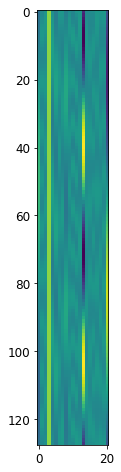

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(FT)
plt.show()

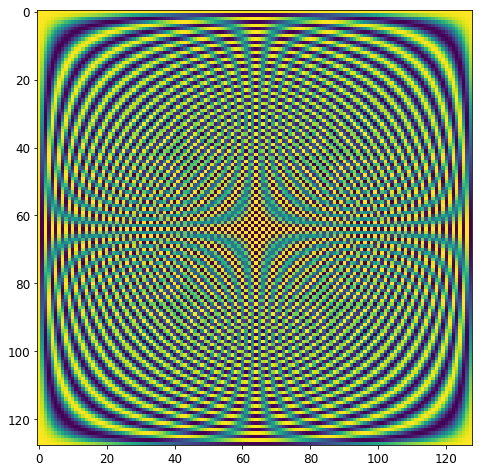

In [14]:
from scipy.linalg import dft

DFT = dft(128)

plt.figure(figsize=(8,8))
plt.imshow(np.real(DFT))
plt.show()

In [13]:
print(np.shape(DFT))

(128, 128)


In [18]:
#u = data_tensor[0,0,:]

# Create white noise
n = 128
ut = np.zeros(n, dtype=np.complex64)
ut[0] = np.random.normal()
ut[1:n//2] = np.random.normal(size=(n//2-1))+1j*np.random.normal(size=(n//2-1))
ut[n//2] = np.random.normal()
ut[n//2+1:] = np.flipud(np.conj(ut[1:n//2]))
u = np.fft.ifft(ut)

v = u.dot(FT)
v_sorted = v[ind]
combined = np.zeros((11)) 
combined[0] = v_sorted[0]
for k in range(10):
    combined[k+1] = np.sqrt(v_sorted[2*k+1]**2+v_sorted[2*k+2]**2)
print(combined)

[-0.10090454  0.22521699  0.27948137  0.08138791  0.02219293  0.03713813
  0.03342327  0.02904413  0.02048494  0.02792396  0.03257803]


/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
u_hat = np.fft.fft(u, n=21)
print(np.absolute(u_hat[:11]))

[0.4251904  0.256797   0.9611835  0.26028827 0.18018527 0.71992034
 0.5026078  0.26846057 0.36872905 0.73705214 0.4737159 ]


/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


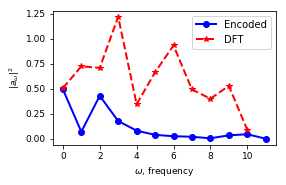

In [41]:
# Plot encoded vs fft
#u = data_tensor[0,0,:]
np.random.seed(0)  
# Create white noise
n = 128
ut = np.zeros(n, dtype=np.complex64)
ut[0] = np.random.normal()
ut[1:n//2] = np.random.normal(size=(n//2-1))+1j*np.random.normal(size=(n//2-1))
ut[n//2] = np.random.normal()
ut[n//2+1:] = np.flipud(np.conj(ut[1:n//2]))
u = np.fft.ifft(ut)

v = u.dot(FT)
v_sorted = v[ind]
#v_sorted = v_sorted*scale
combined = np.zeros((12))
combined[0] = v_sorted[0]
for k in range(10):
    combined[k+1] = np.sqrt(v_sorted[2*k+1]**2+v_sorted[2*k+2]**2)

u_hat = np.fft.fft(u, n=21)
trunc_fft = np.absolute(u_hat[:11])

plt.figure(figsize=(4,2.67))
enc, = plt.plot(combined,'o-b',linewidth=2.0)
dft, = plt.plot(trunc_fft,'*--r',linewidth=2.0)
plt.xlabel('$\omega$, frequency')
plt.ylabel('$|a_{\omega}|^2$')
#plt.xticks(np.arange(0,6.25,3), ['0','3','6'],fontsize=18)
#plt.yticks(np.arange(-10,12,10), ['-10','0','10'],fontsize=18)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.legend([enc,dft],['Encoded','DFT'],fontsize=10)
plt.tight_layout()
filename = '../PDEKoopmanAutoencoder/figures/dft_vs_encoder.eps' 
plt.savefig(filename,format='eps')

/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


[-0.38319454  0.30099194  0.2565449   0.0573969   0.05911165  0.06816336
  0.01486073  0.03028346  0.03377892  0.02870817  0.08885392]
[0.2068443  0.19185396 0.56750965 0.32911476 0.5170649  0.31218597
 0.58709025 0.7543601  0.4012901  0.40844536 0.989185  ]


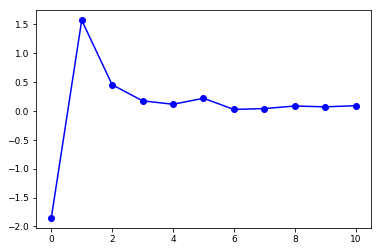

In [32]:
# Plot encoded vs fft
#u = data_tensor[0,0,:]

# Create white noise
n = 128
ut = np.zeros(n, dtype=np.complex64)
ut[0] = np.random.normal()
ut[1:n//2] = np.random.normal(size=(n//2-1))+1j*np.random.normal(size=(n//2-1))
ut[n//2] = np.random.normal()
ut[n//2+1:] = np.flipud(np.conj(ut[1:n//2]))
u = np.fft.ifft(ut)

v = u.dot(FT)
v_sorted = v[ind]
#v_sorted = v_sorted*scale
combined = np.zeros((11))
combined[0] = v_sorted[0]
for k in range(10):
    combined[k+1] = np.sqrt(v_sorted[2*k+1]**2+v_sorted[2*k+2]**2)
print(combined)

u_hat = np.fft.fft(u, n=21)
trunc_fft = np.absolute(u_hat[:11])
print(trunc_fft)

plt.figure()
plt.plot(combined/trunc_fft,'o-b')
plt.show()

In [10]:
from matplotlib.collections import LineCollection

# Waterfall plot function
def waterfall_plot(fig,ax,X,Y,Z,time_in=0,time_out=1,**kwargs):
    '''
    Make a waterfall plot
    Input:
        fig,ax : matplotlib figure and axes to populate
        Z : n,m numpy array. Must be a 2d array even if only one line should be plotted
        X,Y : n,m array
        kwargs : kwargs are directly passed to the LineCollection object
    '''
    # Set normalization to the same values for all plots
    norm = plt.Normalize(Z.min().min(), Z.max().max())
    # Check sizes to loop always over the smallest dimension
    n,m = Z.shape
    if n>m:
        X=X.T; Y=Y.T; Z=Z.T
        m,n = n,m

    for j in range(n):
        # reshape the X,Z into pairs 
        points = np.array([X[j,:], Z[j,:]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)  
        # The values used by the colormap are the input to the array parameter
        if j == time_in:
            #lc = LineCollection(segments, cmap='spring', norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
            cmap = matplotlib.colors.ListedColormap(['red'])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        elif j == time_out:
            cmap = matplotlib.colors.ListedColormap(['blue'])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        else:
            cmap = matplotlib.colors.ListedColormap([[0.5,0.5,0.5]])
            bounds = [Z.min().min(), Z.max().max()]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
            lc = LineCollection(segments, cmap=cmap, norm=norm, array=(Z[j,1:]+Z[j,:-1])/2, **kwargs)
        line = ax.add_collection3d(lc,zs=(Y[j,1:]+Y[j,:-1])/2, zdir='y') # add line to axes

    #fig.colorbar(lc) # add colorbar, as the normalization is the same for all
    # it doesent matter which of the lc objects we use
    ax.auto_scale_xyz(X,Y,Z) # set axis limits

PDEsolvers.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  U[ti,:] = np.fft.ifft(np.exp(-D*k**2*t[ti])*u_0t)


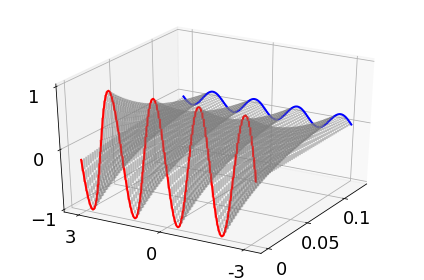

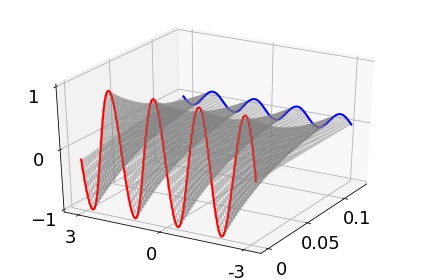

In [9]:
# Plot prediction for sine wave - if 2 side-by-side

# "Exact" solution
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
u_0 = np.sin(4*x_pts)
exact = HeatEqn_FT(D=1,L=2*np.pi,x=x_pts,t=t_pts,u_0=u_0)

# Network
time_steps = 50
current_encoded = np.matmul(u_0,FT)

network = np.zeros((t_pts.size,x_pts.size))

for n_step in xrange(time_steps):
    network[n_step,:] = np.matmul(current_encoded,IFT)
    current_encoded = np.matmul(current_encoded,L_mat)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=18)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=18)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/heat_pred_exact.eps'
plt.savefig(filename,format='eps')  


fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(network),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], network[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], network[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=18)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=18)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=18)
plt.tight_layout()

  
filename = '../PDEKoopmanAutoencoder/figures/heat_pred_network.eps'
plt.savefig(filename,format='eps')


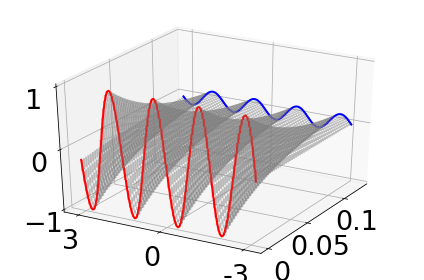

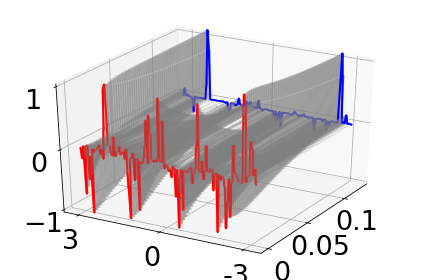

In [14]:
# Plot prediction for sine wave - if 3 side-by-side

# "Exact" solution
x_pts = np.linspace(-np.pi,np.pi,129)
x_pts = x_pts[0:128]
t_pts = np.linspace(0, params['delta_t']*params['num_shifts'],params['num_shifts']+1)
T, X = np.meshgrid(t_pts, x_pts)
u_0 = np.sin(4*x_pts)
exact = HeatEqn_FT(D=1,L=2*np.pi,x=x_pts,t=t_pts,u_0=u_0)

# Network
time_steps = 50
current_encoded = np.matmul(u_0,FT)

network = np.zeros((t_pts.size,x_pts.size))

for n_step in xrange(time_steps):
    network[n_step,:] = np.matmul(current_encoded,IFT)
    current_encoded = np.matmul(current_encoded,L_mat)

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(exact),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], exact[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], exact[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=27)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=27)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=27)
plt.tight_layout()

filename = '../PDEKoopmanAutoencoder/figures/heat_pred_exact.eps'
#plt.savefig(filename,format='eps')  
plt.show()

fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
waterfall_plot(fig,ax,T,X,np.transpose(network),time_in=0,time_out=params['num_shifts'],linewidth=2,alpha=.5) 
ax.plot(T[:,0],X[:,0], network[0,:],'-r',linewidth=2)
ax.plot(T[:,-1],X[:,-1], network[-1,:],'-b',linewidth=2)
ax.view_init(elev=30, azim=210)
plt.xticks(np.arange(0,0.15,0.05), ['0','0.05','0.1'],fontsize=27)
plt.yticks(np.arange(-3,6,3), ['-3','0','3'],fontsize=27)
ax.set_zlim3d(-1, 1)  
ax.set_zticks([-1, 0, 1])
ax.zaxis.set_tick_params(labelsize=27)
plt.tight_layout()

  
#filename = '../PDEKoopmanAutoencoder/figures/heat_pred_network.eps'
filename = '../PDEKoopmanAutoencoder/figures/heat_pred_nonlinear_network.eps'
plt.savefig(filename,format='eps')

In [4]:
# List all graph operations (if necessary to do more post processing)
tf.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph(params['model_path']+'.meta')
    saver.restore(sess, params['model_path'])
     
    graph = tf.get_default_graph()
    for op in graph.get_operations():
        print(op.name)

INFO:tensorflow:Restoring parameters from ./Heat_exp29m/Heat_Eqn_exp29_2019_10_27_00_31_02_732009_model.ckpt
save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
Adam_1/epsilon
Adam_1/beta2
Adam_1/beta1
Adam_1/learning_rate
decoder_outer/hidden2_decode/bias/Adam_3
save/Assign_23
decoder_outer/hidden2_decode/bias/Adam_3/read
decoder_outer/hidden2_decode/bias/Adam_3/Initializer/zeros
decoder_outer/hidden2_decode/bias/Adam_3/Assign
decoder_outer/hidden2_decode/bias/Adam_2
save/Assign_22
decoder_outer/hidden2_decode/bias/Adam_2/read
decoder_outer/hidden2_decode/bias/Adam_2/Initializer/zeros
decoder_outer/hidden2_decode/bias/Adam_2/Assign
decoder_outer/hidden2_decode/kernel/Adam_3
save/Assign_28
decoder_outer/hidden2_decode/kernel/Adam_3/read
decoder_outer/hidden2_decode/kernel/Adam_3/Initializer/zeros/Const
decoder_outer/hidden2_decode/kernel/Adam_3/Initializer/zeros/shape_as_tensor
decoder_outer/hidden2

gradients/Mean_58_grad/Const
gradients/Mean_58_grad/Maximum/y
gradients/Mean_58_grad/Fill/value
gradients/Mean_58_grad/range/delta
gradients/Mean_58_grad/range/start
gradients/Mean_58_grad/Shape_1
gradients/Mean_58_grad/Fill
gradients/Mean_58_grad/Size
gradients/Mean_58_grad/range
gradients/Mean_53_grad/Maximum/y
gradients/Mean_53_grad/Const_1
gradients/Mean_53_grad/Const
gradients/Mean_53_grad/Shape_2
gradients/Mean_53_grad/Prod_1
gradients/Mean_53_grad/Maximum
gradients/Mean_53_grad/Reshape/shape
gradients/Mean_63_grad/Maximum_1/y
gradients/Mean_63_grad/Const_1
gradients/Mean_63_grad/Const
gradients/Mean_63_grad/Maximum/y
gradients/Mean_63_grad/Fill/value
gradients/Mean_63_grad/range/delta
gradients/Mean_63_grad/range/start
gradients/Mean_63_grad/Shape_1
gradients/Mean_63_grad/Fill
gradients/Mean_63_grad/Size
gradients/Mean_63_grad/range
gradients/add_38_grad/Shape_1
gradients/Mean_61_grad/Maximum_1/y
gradients/Mean_61_grad/Const_1
gradients/Mean_61_grad/Const
gradients/Mean_61_grad/

gradients/decoder_outer_38/mul_grad/Shape
gradients/decoder_outer_37/mul_grad/Shape
gradients/decoder_outer_36/mul_grad/Shape
gradients/decoder_outer_35/mul_grad/Shape
gradients/decoder_outer_34/mul_grad/Shape
gradients/decoder_outer_33/mul_grad/Shape
gradients/decoder_outer_32/mul_grad/Shape
gradients/decoder_outer_31/mul_grad/Shape
gradients/decoder_outer_30/mul_grad/Shape
gradients/decoder_outer_29/mul_grad/Shape
gradients/decoder_outer_28/mul_grad/Shape
gradients/decoder_outer_27/mul_grad/Shape
gradients/decoder_outer_26/mul_grad/Shape
gradients/decoder_outer_25/mul_grad/Shape
gradients/decoder_outer_24/mul_grad/Shape
gradients/decoder_outer_23/mul_grad/Shape
gradients/decoder_outer_22/mul_grad/Shape
gradients/decoder_outer_21/mul_grad/Shape
gradients/decoder_outer_20/mul_grad/Shape
gradients/decoder_outer_19/mul_grad/Shape
gradients/decoder_outer_18/mul_grad/Shape
gradients/decoder_outer_17/mul_grad/Shape
gradients/decoder_outer_16/mul_grad/Shape
gradients/decoder_outer_15/mul_gra

decoder_outer_86/Reshape/shape
decoder_outer_85/scalar
decoder_outer_85/Reshape_1/shape
decoder_outer_85/Reshape/shape
decoder_outer_84/scalar
decoder_outer_84/Reshape_1/shape
decoder_outer_84/Reshape/shape
decoder_outer_83/scalar
decoder_outer_83/Reshape_1/shape
decoder_outer_83/Reshape/shape
decoder_outer_82/scalar
decoder_outer_82/Reshape_1/shape
decoder_outer_82/Reshape/shape
decoder_outer_81/scalar
decoder_outer_81/Reshape_1/shape
decoder_outer_81/Reshape/shape
decoder_outer_80/scalar
decoder_outer_80/Reshape_1/shape
decoder_outer_80/Reshape/shape
decoder_outer_79/scalar
decoder_outer_79/Reshape_1/shape
decoder_outer_79/Reshape/shape
decoder_outer_78/scalar
decoder_outer_78/Reshape_1/shape
decoder_outer_78/Reshape/shape
decoder_outer_77/scalar
decoder_outer_77/Reshape_1/shape
decoder_outer_77/Reshape/shape
decoder_outer_76/scalar
decoder_outer_76/Reshape_1/shape
decoder_outer_76/Reshape/shape
decoder_outer_75/scalar
decoder_outer_75/Reshape_1/shape
decoder_outer_75/Reshape/shape
d

gradients/decoder_outer_94/Reshape_grad/Shape
decoder_outer_94/Reshape
decoder_outer_94/hidden1_decode/MatMul
decoder_outer_94/hidden1_decode/BiasAdd
decoder_outer_94/hidden1_decode/Relu
gradients_1/decoder_outer_94/Reshape_1_grad/Shape
gradients/decoder_outer_94/Reshape_1_grad/Shape
decoder_outer_94/Reshape_1
decoder_outer_94/hidden2_decode/MatMul
decoder_outer_94/hidden2_decode/BiasAdd
gradients_1/decoder_outer_94/outputs_grad/Shape
gradients_1/decoder_outer_94/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_94/outputs_grad/Shape
gradients/decoder_outer_94/outputs_grad/BroadcastGradientArgs
decoder_outer_94/outputs
encoder_43/vk_hat
gradients/sub_44_grad/Shape_1
Square_88
gradients/Mean_132_grad/Shape_2
gradients/Mean_132_grad/Prod
gradients/Mean_132_grad/Shape
gradients/Mean_132_grad/DynamicStitch
gradients/Mean_132_grad/Maximum
gradients/Mean_132_grad/floordiv
Mean_132
gradients/Mean_132_grad/Shape_3
gradients/Mean_132_grad/Prod_1
gradients/Mean_132_grad/Maximum_1
gradie

gradients/decoder_outer_88/outputs_grad/BroadcastGradientArgs
decoder_outer_88/outputs
encoder_37/vk_hat
gradients/sub_38_grad/Shape_1
Square_76
gradients/Mean_114_grad/Shape_2
gradients/Mean_114_grad/Prod
gradients/Mean_114_grad/Shape
gradients/Mean_114_grad/DynamicStitch
gradients/Mean_114_grad/Maximum
gradients/Mean_114_grad/floordiv
Mean_114
gradients/Mean_114_grad/Shape_3
gradients/Mean_114_grad/Prod_1
gradients/Mean_114_grad/Maximum_1
gradients/Mean_114_grad/floordiv_1
gradients/Mean_114_grad/Cast
gradients/add_74_grad/Shape
gradients/add_74_grad/BroadcastGradientArgs
add_74
gradients/truediv_38_grad/Shape_1
Identity_126
decoder_inner_38/MatMul
gradients_1/decoder_outer_38/mul_grad/Shape_1
gradients_1/decoder_outer_38/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_38/mul_grad/Shape_1
gradients/decoder_outer_38/mul_grad/BroadcastGradientArgs
decoder_outer_38/mul
gradients_1/decoder_outer_38/outputs_grad/Shape_1
gradients/decoder_outer_38/outputs_grad/Shape_1
Identity_127
d

decoder_outer_79/hidden1_decode/MatMul
decoder_outer_79/hidden1_decode/BiasAdd
decoder_outer_79/hidden1_decode/Relu
gradients_1/decoder_outer_79/Reshape_1_grad/Shape
gradients/decoder_outer_79/Reshape_1_grad/Shape
decoder_outer_79/Reshape_1
decoder_outer_79/hidden2_decode/MatMul
decoder_outer_79/hidden2_decode/BiasAdd
gradients_1/decoder_outer_79/outputs_grad/Shape
gradients_1/decoder_outer_79/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_79/outputs_grad/Shape
gradients/decoder_outer_79/outputs_grad/BroadcastGradientArgs
decoder_outer_79/outputs
encoder_28/vk_hat
gradients/sub_29_grad/Shape_1
Square_58
gradients/Mean_87_grad/Shape_2
gradients/Mean_87_grad/Prod
gradients/Mean_87_grad/Shape
gradients/Mean_87_grad/DynamicStitch
gradients/Mean_87_grad/Maximum
gradients/Mean_87_grad/floordiv
Mean_87
gradients/Mean_87_grad/Shape_3
gradients/Mean_87_grad/Prod_1
gradients/Mean_87_grad/Maximum_1
gradients/Mean_87_grad/floordiv_1
gradients/Mean_87_grad/Cast
gradients/add_56_grad/Sha

gradients/decoder_outer_17/outputs_grad/BroadcastGradientArgs
decoder_outer_17/outputs
strided_slice_15
Squeeze_15
encoder_15/mul
gradients_1/encoder_15/Add_grad/Shape_1
gradients/encoder_15/Add_grad/Shape_1
Identity_15
encoder_15/log_uk
encoder_15/Reshape
encoder_15/hidden1_encode/MatMul
encoder_15/hidden1_encode/BiasAdd
encoder_15/hidden1_encode/Relu
gradients_1/encoder_15/Reshape_1_grad/Shape
gradients/encoder_15/Reshape_1_grad/Shape
encoder_15/Reshape_1
encoder_15/hidden2_encode/MatMul
encoder_15/hidden2_encode/BiasAdd
gradients_1/encoder_15/Add_grad/Shape
gradients_1/encoder_15/Add_grad/BroadcastGradientArgs
gradients/encoder_15/Add_grad/Shape
gradients/encoder_15/Add_grad/BroadcastGradientArgs
encoder_15/Add
encoder_15/v_k
gradients_1/decoder_outer_66/mul_grad/Shape_1
gradients_1/decoder_outer_66/mul_grad/BroadcastGradientArgs
gradients/decoder_outer_66/mul_grad/Shape_1
gradients/decoder_outer_66/mul_grad/BroadcastGradientArgs
decoder_outer_66/mul
gradients_1/decoder_outer_66/out

gradients/decoder_outer_8/mul_grad/BroadcastGradientArgs
decoder_outer_8/mul
gradients_1/decoder_outer_8/outputs_grad/Shape_1
gradients/decoder_outer_8/outputs_grad/Shape_1
Identity_67
decoder_outer_8/log_vkplus1
gradients_1/decoder_outer_8/Reshape_grad/Shape
gradients/decoder_outer_8/Reshape_grad/Shape
decoder_outer_8/Reshape
decoder_outer_8/hidden1_decode/MatMul
decoder_outer_8/hidden1_decode/BiasAdd
decoder_outer_8/hidden1_decode/Relu
gradients_1/decoder_outer_8/Reshape_1_grad/Shape
gradients/decoder_outer_8/Reshape_1_grad/Shape
decoder_outer_8/Reshape_1
decoder_outer_8/hidden2_decode/MatMul
decoder_outer_8/hidden2_decode/BiasAdd
gradients_1/decoder_outer_8/outputs_grad/Shape
gradients_1/decoder_outer_8/outputs_grad/BroadcastGradientArgs
gradients/decoder_outer_8/outputs_grad/Shape
gradients/decoder_outer_8/outputs_grad/BroadcastGradientArgs
decoder_outer_8/outputs
strided_slice_6
Squeeze_6
encoder_6/mul
gradients_1/encoder_6/Add_grad/Shape_1
gradients/encoder_6/Add_grad/Shape_1
Ide

gradients/Tensordot_grad/Reshape
gradients/Tensordot/MatMul_grad/MatMul_1
gradients/Tensordot/MatMul_grad/MatMul
gradients/Tensordot/MatMul_grad/tuple/group_deps
gradients/Tensordot/MatMul_grad/tuple/control_dependency_1
gradients/Tensordot/Reshape_1_grad/Reshape
gradients/Tensordot/transpose_1_grad/transpose
gradients/Tensordot/MatMul_grad/tuple/control_dependency
gradients/Tensordot/Reshape_grad/Reshape
gradients/Tensordot/transpose_grad/transpose
gradients/Tensordot/a_grad/unstack
gradients/Tensordot/a_grad/tuple/group_deps
gradients/Tensordot/a_grad/tuple/control_dependency_49
gradients/Tensordot/a_grad/tuple/control_dependency_48
gradients/Tensordot/a_grad/tuple/control_dependency_47
gradients/Tensordot/a_grad/tuple/control_dependency_46
gradients/Tensordot/a_grad/tuple/control_dependency_45
gradients/Tensordot/a_grad/tuple/control_dependency_44
gradients/Tensordot/a_grad/tuple/control_dependency_43
gradients/Tensordot/a_grad/tuple/control_dependency_42
gradients/Tensordot/a_grad/

gradients_1/decoder_outer_71/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_71/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_71/outputs_grad/tuple/control_dependency
gradients_1/decoder_outer_71/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_71/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_71/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_71/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_71/hidden2_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_71/hidden2_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_71/hidden2_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_71/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_71/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_71/Reshape_1_grad/Reshape
gradients_1/decoder_outer_71/hidden1_decode/Relu_grad/ReluGrad
gradients_1/deco

gradients_1/decoder_outer_63/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_63/Reshape_grad/Reshape
gradients_1/sub_52/y_grad/tuple/control_dependency_11
gradients_1/decoder_outer_62/outputs_grad/Sum_1
gradients_1/decoder_outer_62/outputs_grad/Reshape_1
gradients_1/decoder_outer_62/outputs_grad/Sum
gradients_1/decoder_outer_62/outputs_grad/Reshape
gradients_1/decoder_outer_62/outputs_grad/tuple/group_deps
gradients_1/decoder_outer_62/outputs_grad/tuple/control_dependency_1
gradients_1/decoder_outer_62/mul_grad/Mul_1
gradients_1/decoder_outer_62/mul_grad/Sum_1
gradients_1/decoder_outer_62/mul_grad/Reshape_1
gradients_1/decoder_outer_62/mul_grad/Mul
gradients_1/decoder_outer_62/mul_grad/Sum
gradients_1/decoder_outer_62/mul_grad/Reshape
gradients_1/decoder_outer_62/mul_grad/tuple/group_deps
gradients_1/decoder_outer_62/mul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_62/mul_grad/tuple/control_dependency
gradients_1/decoder_outer_62/outputs_grad/

gradients/decoder_outer_93/mul_grad/Reshape
gradients/decoder_outer_93/mul_grad/tuple/group_deps
gradients/decoder_outer_93/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_93/mul_grad/tuple/control_dependency
gradients/decoder_outer_93/outputs_grad/tuple/control_dependency
gradients/decoder_outer_93/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_93/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_93/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_93/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_93/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_93/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_93/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_93/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_93/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_93/Reshape_1_grad/Reshape
gradient

gradients/decoder_outer_77/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_77/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_77/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_77/hidden1_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_77/hidden1_decode/MatMul_grad/MatMul
gradients/decoder_outer_77/hidden1_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_77/hidden1_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_77/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_77/Reshape_grad/Reshape
gradients/sub_52/y_grad/tuple/control_dependency_25
gradients/decoder_outer_76/outputs_grad/Sum_1
gradients/decoder_outer_76/outputs_grad/Reshape_1
gradients/decoder_outer_76/outputs_grad/Sum
gradients/decoder_outer_76/outputs_grad/Reshape
gradients/decoder_outer_76/outputs_grad/tuple/group_deps
gradients/decoder_outer_76/outputs_grad/tuple/control_dependency_1

gradients/truediv_49_grad/Shape
gradients/truediv_49_grad/BroadcastGradientArgs
truediv_49
gradients/Mean_149_grad/Shape_1
gradients/Mean_149_grad/Prod
gradients/Mean_149_grad/floordiv
gradients/Mean_149_grad/Cast
gradients/Mean_149_grad/Shape
Mean_149
mul_47
sub_48
Square_97
gradients/Mean_145_grad/Shape_2
gradients/Mean_145_grad/Prod
gradients/Mean_145_grad/Shape
gradients/Mean_145_grad/DynamicStitch
gradients/Mean_145_grad/Maximum
gradients/Mean_145_grad/floordiv
Mean_145
gradients/Mean_145_grad/Shape_3
gradients/Mean_145_grad/Prod_1
gradients/Mean_145_grad/Maximum_1
gradients/Mean_145_grad/floordiv_1
gradients/Mean_145_grad/Cast
gradients/truediv_48_grad/Neg
gradients/truediv_48_grad/RealDiv_1
gradients/truediv_48_grad/RealDiv_2
gradients/truediv_48_grad/Shape
gradients/truediv_48_grad/BroadcastGradientArgs
truediv_48
gradients/Mean_146_grad/Shape_1
gradients/Mean_146_grad/Prod
gradients/Mean_146_grad/floordiv
gradients/Mean_146_grad/Cast
gradients/Mean_146_grad/Shape
Mean_146
mul_

sub_19
Square_39
gradients/Mean_58_grad/Shape_2
gradients/Mean_58_grad/Prod
gradients/Mean_58_grad/Shape
gradients/Mean_58_grad/DynamicStitch
gradients/Mean_58_grad/Maximum
gradients/Mean_58_grad/floordiv
Mean_58
gradients/Mean_58_grad/Shape_3
gradients/Mean_58_grad/Prod_1
gradients/Mean_58_grad/Maximum_1
gradients/Mean_58_grad/floordiv_1
gradients/Mean_58_grad/Cast
gradients/truediv_19_grad/Neg
gradients/truediv_19_grad/RealDiv_1
gradients/truediv_19_grad/RealDiv_2
gradients/truediv_19_grad/Shape
gradients/truediv_19_grad/BroadcastGradientArgs
truediv_19
gradients/Mean_59_grad/Shape_1
gradients/Mean_59_grad/Prod
gradients/Mean_59_grad/floordiv
gradients/Mean_59_grad/Cast
gradients/Mean_59_grad/Shape
Mean_59
mul_17
sub_18
Square_37
gradients/Mean_55_grad/Shape_2
gradients/Mean_55_grad/Prod
gradients/Mean_55_grad/Shape
gradients/Mean_55_grad/DynamicStitch
gradients/Mean_55_grad/Maximum
gradients/Mean_55_grad/floordiv
Mean_55
gradients/Mean_55_grad/Shape_3
gradients/Mean_55_grad/Prod_1
g

gradients/Square_98_grad/Mul_1
gradients/truediv_49_grad/tuple/control_dependency
gradients/Mean_148_grad/Reshape
gradients/Mean_148_grad/Tile
gradients/Mean_148_grad/truediv
gradients/Square_99_grad/Const
gradients/Square_99_grad/Mul
gradients/Square_99_grad/Mul_1
gradients/sub_49_grad/Sum_1
gradients/sub_49_grad/Neg
gradients/sub_49_grad/Reshape_1
gradients/sub_49_grad/Sum
gradients/sub_49_grad/Reshape
gradients/sub_49_grad/tuple/group_deps
gradients/sub_49_grad/tuple/control_dependency_1
gradients/sub_49_grad/tuple/control_dependency
gradients/AddN
gradients/MatMul_97_grad/MatMul_1
gradients/MatMul_97_grad/MatMul
gradients/MatMul_97_grad/tuple/group_deps
gradients/MatMul_97_grad/tuple/control_dependency_1
gradients/MatMul_97_grad/tuple/control_dependency
gradients/mul_47_grad/tuple/control_dependency
gradients/add_97_grad/tuple/control_dependency
gradients/add_95_grad/tuple/group_deps
gradients/add_95_grad/tuple/control_dependency_1
gradients/mul_46_grad/Mul_1
gradients/mul_46_grad/

gradients/Square_72_grad/Mul_1
gradients/truediv_36_grad/tuple/control_dependency
gradients/Mean_109_grad/Reshape
gradients/Mean_109_grad/Tile
gradients/Mean_109_grad/truediv
gradients/Square_73_grad/Const
gradients/Square_73_grad/Mul
gradients/Square_73_grad/Mul_1
gradients/sub_36_grad/Sum_1
gradients/sub_36_grad/Neg
gradients/sub_36_grad/Reshape_1
gradients/sub_36_grad/Sum
gradients/sub_36_grad/Reshape
gradients/sub_36_grad/tuple/group_deps
gradients/sub_36_grad/tuple/control_dependency_1
gradients/sub_36_grad/tuple/control_dependency
gradients/AddN_149
gradients/MatMul_84_grad/MatMul_1
gradients/MatMul_84_grad/MatMul
gradients/MatMul_84_grad/tuple/group_deps
gradients/MatMul_84_grad/tuple/control_dependency_1
gradients/MatMul_84_grad/tuple/control_dependency
gradients/mul_34_grad/tuple/control_dependency
gradients/add_71_grad/tuple/control_dependency
gradients/add_69_grad/tuple/group_deps
gradients/add_69_grad/tuple/control_dependency_1
gradients/mul_33_grad/Mul_1
gradients/mul_33_g

gradients/add_36_grad/tuple/control_dependency
gradients/Mean_57_grad/Reshape
gradients/Mean_57_grad/Tile
gradients/Mean_57_grad/truediv
gradients/Square_38_grad/Const
gradients/Square_38_grad/Mul
gradients/Square_38_grad/Mul_1
gradients/truediv_19_grad/tuple/control_dependency
gradients/Mean_58_grad/Reshape
gradients/Mean_58_grad/Tile
gradients/Mean_58_grad/truediv
gradients/Square_39_grad/Const
gradients/Square_39_grad/Mul
gradients/Square_39_grad/Mul_1
gradients/sub_19_grad/Sum_1
gradients/sub_19_grad/Neg
gradients/sub_19_grad/Reshape_1
gradients/sub_19_grad/Sum
gradients/sub_19_grad/Reshape
gradients/sub_19_grad/tuple/group_deps
gradients/sub_19_grad/tuple/control_dependency_1
gradients/sub_19_grad/tuple/control_dependency
gradients/AddN_217
gradients/MatMul_67_grad/MatMul_1
gradients/MatMul_67_grad/MatMul
gradients/MatMul_67_grad/tuple/group_deps
gradients/MatMul_67_grad/tuple/control_dependency_1
gradients/MatMul_67_grad/tuple/control_dependency
gradients/mul_17_grad/tuple/contro

gradients/mul_5_grad/tuple/control_dependency_1
gradients/Mean_23_grad/Reshape
gradients/Mean_23_grad/Tile
gradients/Mean_23_grad/truediv
gradients/truediv_7_grad/mul
gradients/truediv_7_grad/Sum_1
gradients/truediv_7_grad/Reshape_1
gradients/truediv_7_grad/RealDiv
gradients/truediv_7_grad/Sum
gradients/truediv_7_grad/Reshape
gradients/truediv_7_grad/tuple/group_deps
gradients/truediv_7_grad/tuple/control_dependency_1
gradients/add_12_grad/Sum_1
gradients/add_12_grad/Reshape_1
gradients/add_12_grad/Sum
gradients/add_12_grad/Reshape
gradients/add_12_grad/tuple/group_deps
gradients/add_12_grad/tuple/control_dependency_1
gradients/add_12_grad/tuple/control_dependency
gradients/Mean_21_grad/Reshape
gradients/Mean_21_grad/Tile
gradients/Mean_21_grad/truediv
gradients/Square_14_grad/Const
gradients/Square_14_grad/Mul
gradients/Square_14_grad/Mul_1
gradients/truediv_7_grad/tuple/control_dependency
gradients/Mean_22_grad/Reshape
gradients/Mean_22_grad/Tile
gradients/Mean_22_grad/truediv
gradie

gradients/decoder_outer_113/mul_grad/Shape_1
gradients/decoder_outer_113/mul_grad/BroadcastGradientArgs
decoder_outer_113/mul
gradients/decoder_outer_113/outputs_grad/Shape_1
Identity_227
decoder_outer_113/log_vkplus1
gradients/decoder_outer_113/Reshape_grad/Shape
decoder_outer_113/Reshape
decoder_outer_113/hidden1_decode/MatMul
decoder_outer_113/hidden1_decode/BiasAdd
decoder_outer_113/hidden1_decode/Relu
gradients/decoder_outer_113/Reshape_1_grad/Shape
decoder_outer_113/Reshape_1
decoder_outer_113/hidden2_decode/MatMul
decoder_outer_113/hidden2_decode/BiasAdd
gradients/decoder_outer_113/outputs_grad/Shape
gradients/decoder_outer_113/outputs_grad/BroadcastGradientArgs
decoder_outer_113/outputs
Identity_224
decoder_inner_62/MatMul
gradients/decoder_outer_112/mul_grad/Shape_1
gradients/decoder_outer_112/mul_grad/BroadcastGradientArgs
decoder_outer_112/mul
gradients/decoder_outer_112/outputs_grad/Shape_1
Identity_225
decoder_outer_112/log_vkplus1
gradients/decoder_outer_112/Reshape_grad/

gradients/decoder_outer_148/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_148/Reshape_grad/Reshape
gradients/AddN_109
gradients/decoder_inner_98/MatMul_grad/MatMul_1
gradients/decoder_inner_98/MatMul_grad/MatMul
gradients/decoder_inner_98/MatMul_grad/tuple/group_deps
gradients/decoder_inner_98/MatMul_grad/tuple/control_dependency_1
gradients/decoder_inner_98/MatMul_grad/tuple/control_dependency
gradients/AddN_138
gradients/MatMul_47_grad/MatMul_1
gradients/MatMul_47_grad/MatMul
gradients/MatMul_47_grad/tuple/group_deps
gradients/MatMul_47_grad/tuple/control_dependency_1
gradients/MatMul_47_grad/tuple/control_dependency
gradients/sub_1/y_grad/tuple/control_dependency_46
gradients/decoder_outer_147/outputs_grad/Sum_1
gradients/decoder_outer_147/outputs_grad/Reshape_1
gradients/decoder_outer_147/outputs_grad/Sum
gradients/decoder_outer_147/outputs_grad/Reshape
gradients/decoder_outer_147/outputs_grad/tuple/group_deps
gradients/decoder_outer_147/outputs_grad/t

gradients/decoder_outer_135/mul_grad/Mul
gradients/decoder_outer_135/mul_grad/Sum
gradients/decoder_outer_135/mul_grad/Reshape
gradients/decoder_outer_135/mul_grad/tuple/group_deps
gradients/decoder_outer_135/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_135/mul_grad/tuple/control_dependency
gradients/decoder_outer_135/outputs_grad/tuple/control_dependency
gradients/decoder_outer_135/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_135/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_135/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_135/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_135/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_135/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_135/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_135/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_135/hidden2_decode

gradients/decoder_outer_117/outputs_grad/Sum
gradients/decoder_outer_117/outputs_grad/Reshape
gradients/decoder_outer_117/outputs_grad/tuple/group_deps
gradients/decoder_outer_117/outputs_grad/tuple/control_dependency_1
gradients/decoder_outer_117/mul_grad/Mul_1
gradients/decoder_outer_117/mul_grad/Sum_1
gradients/decoder_outer_117/mul_grad/Reshape_1
gradients/decoder_outer_117/mul_grad/Mul
gradients/decoder_outer_117/mul_grad/Sum
gradients/decoder_outer_117/mul_grad/Reshape
gradients/decoder_outer_117/mul_grad/tuple/group_deps
gradients/decoder_outer_117/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_117/mul_grad/tuple/control_dependency
gradients/decoder_outer_117/outputs_grad/tuple/control_dependency
gradients/decoder_outer_117/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_117/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_117/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_117/hidden2_decode/BiasAdd

gradients/decoder_outer_101/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_101/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_101/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_101/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_101/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_101/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_101/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_101/Reshape_1_grad/Reshape
gradients/decoder_outer_101/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_101/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_101/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_101/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_101/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_101/hidden1_decode/MatMul_grad/Mat

gradients_1/decoder_outer_44/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_44/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_44/Reshape_1_grad/Reshape
gradients_1/decoder_outer_44/hidden1_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_44/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_44/hidden1_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_44/hidden1_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_44/hidden1_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_44/hidden1_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_44/hidden1_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_44/Reshape_grad/Resha

gradients_1/encoder_33/Add_grad/Reshape
gradients_1/encoder_33/Add_grad/tuple/group_deps
gradients_1/encoder_33/Add_grad/tuple/control_dependency_1
gradients_1/encoder_33/Add_grad/tuple/control_dependency
gradients_1/encoder_33/hidden2_encode/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_33/hidden2_encode/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_33/hidden2_encode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_33/hidden2_encode/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_33/hidden2_encode/MatMul_grad/MatMul_1
gradients_1/encoder_33/hidden2_encode/MatMul_grad/MatMul
gradients_1/encoder_33/hidden2_encode/MatMul_grad/tuple/group_deps
gradients_1/encoder_33/hidden2_encode/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_33/hidden2_encode/MatMul_grad/tuple/control_dependency
gradients_1/encoder_33/Reshape_1_grad/Reshape
gradients_1/encoder_33/hidden1_encode/Relu_grad/ReluGrad
gradients_1/encoder_33/hidden1_encode/BiasAdd_grad/BiasAddGrad
gradients

gradients_1/decoder_outer_15/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_15/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_15/hidden2_decode/MatMul_grad/MatMul_1
gradients_1/decoder_outer_15/hidden2_decode/MatMul_grad/MatMul
gradients_1/decoder_outer_15/hidden2_decode/MatMul_grad/tuple/group_deps
gradients_1/decoder_outer_15/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients_1/decoder_outer_15/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients_1/decoder_outer_15/Reshape_1_grad/Reshape
gradients_1/decoder_outer_15/hidden1_decode/Relu_grad/ReluGrad
gradients_1/decoder_outer_15/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients_1/decoder_outer_15/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients_1/decoder_outer_15/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/decoder_outer_15/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients_1/decoder_outer_15/hidden1_decode/M

gradients_1/encoder_5/Add_grad/Reshape_1
gradients_1/encoder_5/Add_grad/Sum
gradients_1/encoder_5/Add_grad/Reshape
gradients_1/encoder_5/Add_grad/tuple/group_deps
gradients_1/encoder_5/Add_grad/tuple/control_dependency_1
gradients_1/encoder_5/Add_grad/tuple/control_dependency
gradients_1/encoder_5/hidden2_encode/BiasAdd_grad/BiasAddGrad
gradients_1/encoder_5/hidden2_encode/BiasAdd_grad/tuple/group_deps
gradients_1/encoder_5/hidden2_encode/BiasAdd_grad/tuple/control_dependency_1
gradients_1/encoder_5/hidden2_encode/BiasAdd_grad/tuple/control_dependency
gradients_1/encoder_5/hidden2_encode/MatMul_grad/MatMul_1
gradients_1/encoder_5/hidden2_encode/MatMul_grad/MatMul
gradients_1/encoder_5/hidden2_encode/MatMul_grad/tuple/group_deps
gradients_1/encoder_5/hidden2_encode/MatMul_grad/tuple/control_dependency_1
gradients_1/encoder_5/hidden2_encode/MatMul_grad/tuple/control_dependency
gradients_1/encoder_5/Reshape_1_grad/Reshape
gradients_1/encoder_5/hidden1_encode/Relu_grad/ReluGrad
gradients_1

gradients/sub/y_grad/tuple/control_dependency_45
gradients/decoder_outer_46/outputs_grad/Sum_1
gradients/decoder_outer_46/outputs_grad/Reshape_1
gradients/decoder_outer_46/outputs_grad/Sum
gradients/decoder_outer_46/outputs_grad/Reshape
gradients/decoder_outer_46/outputs_grad/tuple/group_deps
gradients/decoder_outer_46/outputs_grad/tuple/control_dependency_1
gradients/decoder_outer_46/mul_grad/Mul_1
gradients/decoder_outer_46/mul_grad/Sum_1
gradients/decoder_outer_46/mul_grad/Reshape_1
gradients/decoder_outer_46/mul_grad/Mul
gradients/decoder_outer_46/mul_grad/Sum
gradients/decoder_outer_46/mul_grad/Reshape
gradients/decoder_outer_46/mul_grad/tuple/group_deps
gradients/decoder_outer_46/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_46/mul_grad/tuple/control_dependency
gradients/decoder_outer_46/outputs_grad/tuple/control_dependency
gradients/decoder_outer_46/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_46/hidden2_decode/BiasAdd_grad/tuple/group_deps
grad

gradients/decoder_outer_34/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_34/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_34/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_34/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_34/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_34/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_34/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_34/Reshape_1_grad/Reshape
gradients/decoder_outer_34/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_34/hidden1_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_34/hidden1_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_34/hidden1_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_34/hidden1_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_34/hidden1_decode/MatMul_grad/MatMul_1
gradient

gradients/decoder_outer_22/mul_grad/tuple/control_dependency_1
gradients/decoder_outer_22/mul_grad/tuple/control_dependency
gradients/decoder_outer_22/outputs_grad/tuple/control_dependency
gradients/decoder_outer_22/hidden2_decode/BiasAdd_grad/BiasAddGrad
gradients/decoder_outer_22/hidden2_decode/BiasAdd_grad/tuple/group_deps
gradients/decoder_outer_22/hidden2_decode/BiasAdd_grad/tuple/control_dependency_1
gradients/decoder_outer_22/hidden2_decode/BiasAdd_grad/tuple/control_dependency
gradients/decoder_outer_22/hidden2_decode/MatMul_grad/MatMul_1
gradients/decoder_outer_22/hidden2_decode/MatMul_grad/MatMul
gradients/decoder_outer_22/hidden2_decode/MatMul_grad/tuple/group_deps
gradients/decoder_outer_22/hidden2_decode/MatMul_grad/tuple/control_dependency_1
gradients/decoder_outer_22/hidden2_decode/MatMul_grad/tuple/control_dependency
gradients/decoder_outer_22/Reshape_1_grad/Reshape
gradients/decoder_outer_22/hidden1_decode/Relu_grad/ReluGrad
gradients/decoder_outer_22/hidden1_decode/Bi

gradients/encoder_10/hidden2_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_10/hidden2_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_10/hidden2_encode/MatMul_grad/MatMul_1
gradients/encoder_10/hidden2_encode/MatMul_grad/MatMul
gradients/encoder_10/hidden2_encode/MatMul_grad/tuple/group_deps
gradients/encoder_10/hidden2_encode/MatMul_grad/tuple/control_dependency_1
gradients/encoder_10/hidden2_encode/MatMul_grad/tuple/control_dependency
gradients/encoder_10/Reshape_1_grad/Reshape
gradients/encoder_10/hidden1_encode/Relu_grad/ReluGrad
gradients/encoder_10/hidden1_encode/BiasAdd_grad/BiasAddGrad
gradients/encoder_10/hidden1_encode/BiasAdd_grad/tuple/group_deps
gradients/encoder_10/hidden1_encode/BiasAdd_grad/tuple/control_dependency_1
gradients/encoder_10/hidden1_encode/BiasAdd_grad/tuple/control_dependency
gradients/encoder_10/hidden1_encode/MatMul_grad/MatMul_1
gradients/encoder_10/hidden1_encode/MatMul_grad/MatMul
gradients/encoder_10/hidden1_encode/M